In [1]:
import torch
from torch import nn # It contains all the functions of pytorch's building blocks
import matplotlib.pyplot as plt

torch.__version__

'2.4.0'

## DATA can be almost anything you want, but it must be a list of strings or numbers.

In [2]:
# Create known parameters
weight = 0.1
bias = 0.3

# Create 
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(1) # It creates a tensor of shape (10, 1)
y = weight * X + bias

X, y, len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800],
         [0.4000],
         [0.4200],
         [0.4400],
         [0.4600],
         [0.4800],
         [0.5000],
         [0.5200],
         [0.5400],
         [0.5600],
         [0.5800],
         [0.6000],
         [0.6200],
         [0.6400],
         [0.6600],
         [0.6800],
         [0.7000],
         [0.7200],
         [0.7400],
         [0.7600],
         [0.7800],
         [0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.3000],
         [0.3020],
         [

### Split the data into two parts: training data and testing data.

In [3]:
train_split = int(0.8 * len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([40, 1]) torch.Size([40, 1]) torch.Size([10, 1]) torch.Size([10, 1])


In [4]:
import time

# Real time training and testing losses plot

def plot_losses(train_losses, test_losses):
  """
  Plots the training and test losses.
  """
  plt.figure(figsize=(10, 7))
  plt.plot(train_losses, label="Training loss", c="b")
  plt.plot(test_losses, label="Test loss", c="r")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

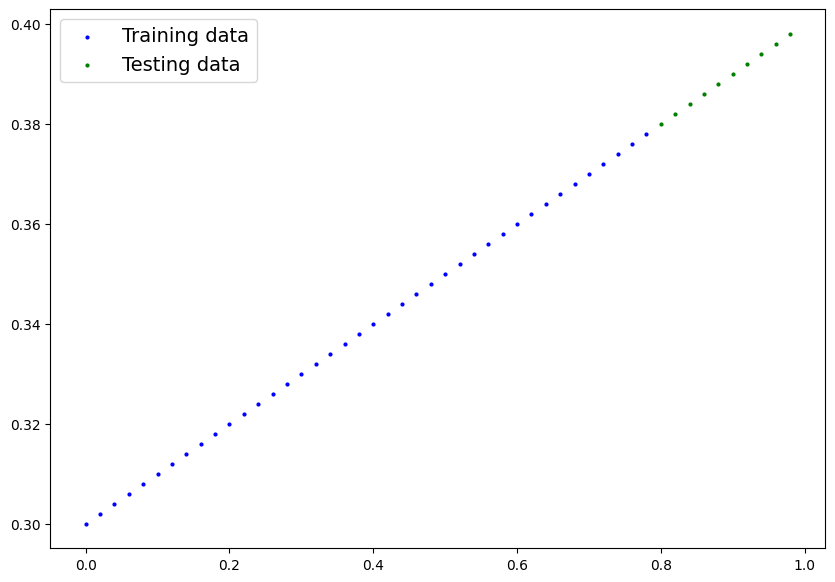

In [5]:
plot_predictions();

## Build Model

In [6]:
class LinearRegressionModule(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
      super().__init__() # <- super() is used to call the __init__ of the parent class (nn.Module). Without this, the model won't work.
      """
        Inside the __init__ method we instantiate the weights and biases
        We use nn.Parameter to tell PyTorch these are values we want to learn
        Initialize model parameters to be used in various computations (these could be different layers from torch.nn, single p)
      """
      self.weights = nn.Parameter(
         torch.randn(1, dtype=torch.float32), 
         requires_grad=True) # nn.Parameter is a tensor that's both a model parameter and a buffer. requires_grad=True tells PyTorch to calculate gradients for this tensor
      self.bias = nn.Parameter(
         torch.randn(1, dtype=torch.float32), 
         requires_grad=True)

    # For the forward method, we take in the inputs and perform the operation of the model
    # Does the forward pass of the model (the operation the model is performing) 
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

## Checking the contents of our model

### Let's see what our model looks like. We will print the model's parameters.

In [7]:
# torch.manual_seed(42)

# # Instantiate the model
# lr_model = LinearRegressionModule()

# # Check the model's parameters
# list(lr_model.parameters())
# lr_model.state_dict()

## Making predictions using torch.inference_mode()
### To check the model's predictive power, let's see how well it predicts y_test based on X_test. When we pass data through our model, it;s going to run it through the forward function.

In [8]:
# with torch.inference_mode():
#   # Make predictions
#   predictions = lr_model(X_test)

# # Plot the predictions
# plot_predictions(predictions=predictions)

## Training the model
The whole idea of training is for a model to move from some *unnown* parameters to some *known* parameters. We do this by comparing the model's predictions to the actual values and adjusting the model's parameters accordingly.

Things we need to train a model:
* **Loss Function**: A way to measure how wrong the model's predictions are compared to the actual values. Lower is better.
* **Optimizer**: A way to adjust the model's parameters based on the gradients of the loss function. Weight and bias are adjusted in the direction that reduces the loss.

And specifically for PyTorch, we need
* A training loop
* A test loop

In [9]:
# loss_fn = nn.MSELoss() # <- this is the mean squared error loss function
# optimizer = torch.optim.SGD(lr_model.parameters(), lr=0.01) # <- this is the stochastic gradient descent optimizer

### Training loop
0. Loop through the training data
1. Forward pass: Compute the predicted y by passing x to the model
2. Calculate the loss (how far off the predicted y is from the actual y)
3. Optimizer: Zero the gradients. This is because PyTorch accumulates gradients on subsequent backward passes. This is useful in RNNs and other sequential data. But for us, we don't need this feature.
4. Loss.backward(): Compute the gradient of the loss with respect to all the model's parameters
5. Optimizer.step(): Update the model's parameters based on the gradients. it's like the model is learning from its mistakes.

In [10]:
# epochs = 5000

# # Track different losses
# epoch_counter = []
# training_losses = []
# test_losses = []


# # Train the model
# for epoch in range(epochs):
#     # set the model to the training mode
#     lr_model.train() # Train mode in PyTorch sets all parameters to be trainable. This is the default mode for nn.Module. It turns on the gradients for all parameters.

#     # Zero the gradients
#     optimizer.zero_grad() # <- this is required because PyTorch accumulates gradients (it sums them up) by default

#     # Forward pass
#     predictions = lr_model(X_train) # <- this is the forward pass

#     # Calculate the loss
#     loss = loss_fn(y_train, predictions) # <- this calculates the loss

#     # Backward pass
#     loss.backward() # <- this calculates the gradients

#     # Step the optimizer (It performs gradient descent and updates the weights)
#     optimizer.step() # <- this updates the weights


#     ### Test the model
#     # set the model to evaluation mode
#     lr_model.eval() # <- this sets the model to evaluation mode. This turns off the gradients for all parameters.

#     with torch.inference_mode():
#         # Make predictions and Forward pass
#         test_predictions = lr_model(X_test)

#         # calculate the loss
#         test_loss = loss_fn(y_test, test_predictions)

#     if epoch % 100 == 0:
#         epoch_counter.append(epoch)
#         training_losses.append(loss.item())
#         test_losses.append(test_loss.item())
#         print(f"Epoch {epoch} - Loss: {loss.item()} - Test Loss: {test_loss.item()}")
#         plot_predictions(predictions=test_predictions)


## Trining Model with Function

In [11]:
def train_model(model, X_train, y_train, X_test, y_test, loss_fn, optimizer, epochs):
    # Track different losses
    epoch_counter = []
    training_losses = []
    test_losses = []

    # Train the model
    for epoch in range(epochs):
        # set the model to the training mode
        model.train()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_train)

        # Calculate the loss
        loss = loss_fn(y_train, predictions)

        # Backward pass
        loss.backward()

        # Step the optimizer
        optimizer.step()

        ### Test the model
        # set the model to evaluation mode
        model.eval()

        with torch.inference_mode():
            # Make predictions and Forward pass
            test_predictions = model(X_test)

            # calculate the loss
            test_loss = loss_fn(y_test, test_predictions)

        if epoch % 100 == 0:
            epoch_counter.append(epoch)
            training_losses.append(loss.item())
            test_losses.append(test_loss.item())
            print(f"Epoch {epoch} - Loss: {loss.item()} - Test Loss: {test_loss.item()}")

    return model, epoch_counter, training_losses, test_losses

In [12]:
torch.manual_seed(42)

# Instantiate the model
lr_model = LinearRegressionModule()

# Check the model's parameters
prev_params = lr_model.parameters()

# Assign the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=0.01)

# Train the model
lr_model, epoch_counter, training_losses, test_losses = train_model(lr_model, X_train, y_train, X_test, y_test, loss_fn, optimizer, epochs=5000)

Epoch 0 - Loss: 0.009208260104060173 - Test Loss: 0.001896462170407176
Epoch 100 - Loss: 0.0031323705334216356 - Test Loss: 0.011653861962258816
Epoch 200 - Loss: 0.0025645066052675247 - Test Loss: 0.011039773002266884
Epoch 300 - Loss: 0.0021331910975277424 - Test Loss: 0.009306302294135094
Epoch 400 - Loss: 0.0017747307429090142 - Test Loss: 0.007753150071948767
Epoch 500 - Loss: 0.0014765107771381736 - Test Loss: 0.006451267749071121
Epoch 600 - Loss: 0.001228401088155806 - Test Loss: 0.00536729209125042
Epoch 700 - Loss: 0.0010219825198873878 - Test Loss: 0.004465391859412193
Epoch 800 - Loss: 0.0008502515265718102 - Test Loss: 0.0037150357384234667
Epoch 900 - Loss: 0.0007073768647387624 - Test Loss: 0.0030907662585377693
Epoch 1000 - Loss: 0.0005885104183107615 - Test Loss: 0.0025714028161019087
Epoch 1100 - Loss: 0.0004896183381788433 - Test Loss: 0.002139307325705886
Epoch 1200 - Loss: 0.0004073443415109068 - Test Loss: 0.001779818907380104
Epoch 1300 - Loss: 0.0003388947225175

In [13]:
print("Model's parameters before and after training:")
for prev_param, new_param in zip(prev_params, lr_model.parameters()):
    print(f"Before: {prev_param} - After: {new_param}")

Model's parameters before and after training:
Before: Parameter containing:
tensor([0.1026], requires_grad=True) - After: Parameter containing:
tensor([0.1026], requires_grad=True)
Before: Parameter containing:
tensor([0.2989], requires_grad=True) - After: Parameter containing:
tensor([0.2989], requires_grad=True)


### Plotting the losses

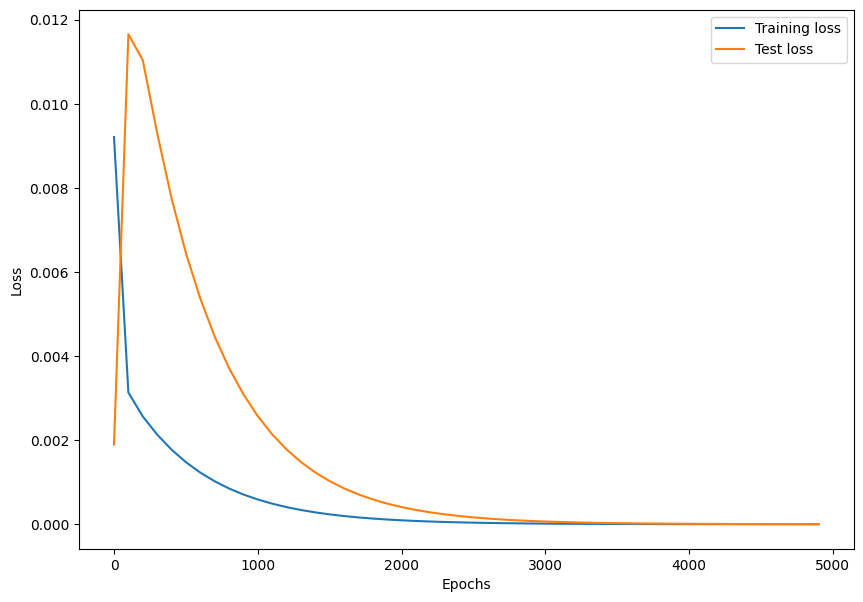

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(epoch_counter, training_losses, label="Training loss")
plt.plot(epoch_counter, test_losses, label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


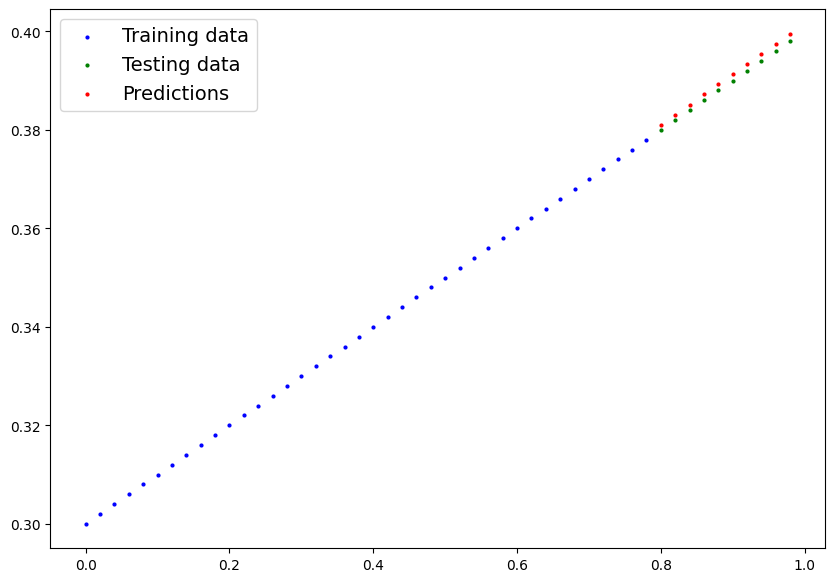

In [16]:
with torch.inference_mode():
    # Make predictions
    predictions_new = lr_model(X_test)
plot_predictions(predictions=predictions_new)

## Saving the model

There are three main ways to save a model in PyTorch:
1. `torch.save()`: Saves a model's state_dict, which is a Python dictionary that maps each layer to its parameters.
2. `torch.load()`: Loads a model's state_dict.
3. `model.load_state_dict()`: Loads a model's state_dict into the model.

In [19]:
from pathlib import Path

# Save the model
models_dir = Path("/home/lelouch/Code/ML_Tutorial/models")
models_dir.mkdir(exist_ok=True)
model_path = models_dir / "linear_regression_model.pt"
torch.save(lr_model.state_dict(), model_path)

## Loading the model

In [23]:
# To load in a saved state dict, you need to create a new model instance and load in the state dict using the load_state_dict method

# Instantiate the model
lr_model_loaded = LinearRegressionModule()

# Load the model's state dict
lr_model_loaded.load_state_dict(torch.load(model_path))

lr_model_loaded.state_dict()

/tmp/ipykernel_10826/817366171.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lr_model_loaded.load_state_dict(torch.load(model_path))


OrderedDict([('weights', tensor([0.1026])), ('bias', tensor([0.2989]))])

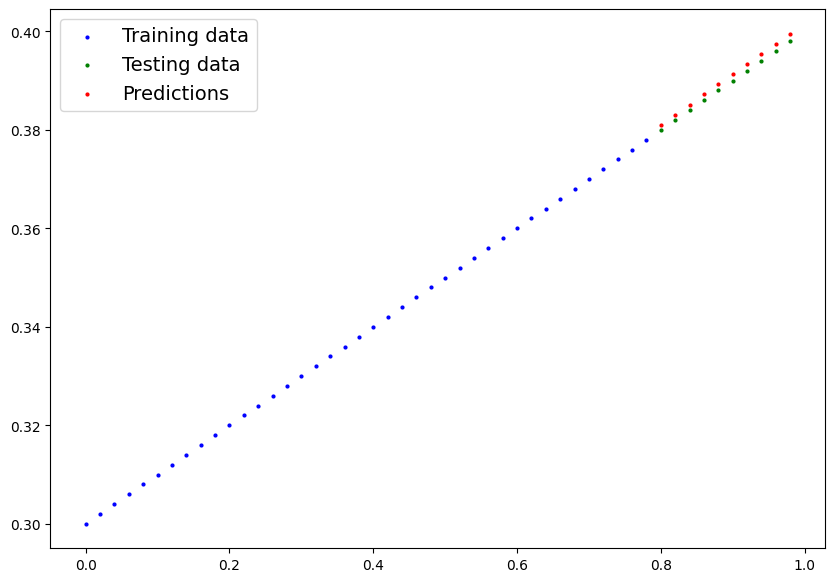

In [24]:
# Make predictions

lr_model_loaded

with torch.inference_mode():
    # Make predictions
    predictions_loaded = lr_model_loaded(X_test)

plot_predictions(predictions=predictions_loaded)